# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    KFold,
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.feature_selection import SelectKBest, chi2, RFECV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from glob import glob
import warnings
import numpy as np

warnings.filterwarnings("ignore")

In [2]:
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
stratifed_kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
random_state = 1

# Load Data

In [3]:
paths = glob("../data/processed/*.csv")

In [4]:
dfs_names = [path.split("/")[-1].split(".")[0].split("\\")[-1] for path in paths]

In [5]:
dfs = [pd.read_csv(path) for path in paths]

In [6]:
df = dfs[7].copy()
df_name = dfs_names[7]

In [7]:
df.head()

,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,...,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PATHOLOGICAL_COMPLEXITY,PERCENT_COMMENTS,LOC_TOTAL,Defective
0,0.0,11.0,1.0,0.0,0.0,0.0,10.0,0.71,0.0,2.29053,...,0.67,37.0,57.0,21.0,15.0,15.0,1.0,0.00,14.0,False
1,8.0,7.0,15.0,0.0,6.0,8.0,4.0,0.15,4.0,2.00000,...,0.10,48.0,60.0,39.0,13.0,41.0,1.0,18.75,26.0,False
2,1.0,5.0,4.0,0.0,0.0,8.0,3.0,0.27,4.0,2.00000,...,0.23,20.0,25.0,14.0,9.0,13.0,1.0,0.00,11.0,False
3,2.0,5.0,0.0,0.0,4.0,8.0,3.0,0.33,4.0,2.00000,...,0.19,10.0,17.0,6.0,9.0,16.0,1.0,30.77,9.0,False
4,4.0,9.0,4.0,0.0,6.0,12.0,5.0,0.33,4.0,3.00000,...,0.19,32.0,33.0,16.0,12.0,26.0,1.0,28.57,15.0,False


In [8]:
df_copy = df.copy()

## Feature Scaling

In [9]:
def scale_data(X_train, X_test, scaler=None):
    """Scale the data"""

    scaler = StandardScaler() if scaler is None else scaler
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

In [10]:
def prepare_data(df, target, over_sampler=None, scaler=None):
    """Prepare the data for training"""
    X = df.drop(target, axis=1)
    y = df[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # Scale the data with StandardScaler
    X_train_scaled, X_test_scaled = scale_data(X_train, X_test, scaler=scaler)

    # Apply over sampling if provided
    if over_sampler is not None:
        X_train_scaled, y_train = over_sampler.fit_resample(X_train_scaled, y_train)
    return X_train_scaled, X_test_scaled, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = prepare_data(df.copy(), "Defective")

# Modeling 

## Metrics

In [12]:
def show_metrics(model_name, model, X_test, y_test, show=True):
    """Show the Confusion Matrix and Classification Report for the model."""

    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = model.score(X_test, y_test)
    if show:
        print(f"Metrics for {model_name}")
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        print("Accuracy:", accuracy)
    return precision, recall, f1, accuracy

## Training Pipeline

In [13]:
def create_pipeline(classifier, feature_selector=None):
    """Create a pipeline with a feature selector and a classifier"""

    if feature_selector is None:
        pipeline = Pipeline(
            steps=[
                ("classifier", classifier),
            ]
        )
        return pipeline

    pipeline = Pipeline(
        steps=[
            ("feature_selector", feature_selector),
            ("classifier", classifier),
        ]
    )
    return pipeline

## Support Vector Machine

In [14]:
svm = create_pipeline(SVC(C=10, gamma=10, kernel="linear"))

In [15]:
svm.fit(X_train, y_train)

Pipeline(steps=[('classifier', SVC(C=10, gamma=10, kernel='linear'))])

In [16]:
svm_metrics = show_metrics("SVM", svm, X_test, y_test, show=True)

Metrics for SVM
Precision: 0.5
Recall: 0.08333333333333333
F1 Score: 0.14285714285714285
Accuracy: 0.8441558441558441


## Random Forest

In [17]:
rfc = create_pipeline(RandomForestClassifier(random_state=random_state))

In [18]:
rfc.fit(X_train, y_train)

Pipeline(steps=[('classifier', RandomForestClassifier(random_state=1))])

In [19]:
rf_metrics = show_metrics("Random Forest", rfc, X_test, y_test, show=True)

Metrics for Random Forest
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy: 0.8311688311688312


## Logistic Regression

In [20]:
lr = create_pipeline(LogisticRegression(C=10))

In [21]:
lr.fit(X_train, y_train)

Pipeline(steps=[('classifier', LogisticRegression(C=10))])

In [22]:
lr_metrics = show_metrics("Logistic Regression", lr, X_test, y_test, show=True)

Metrics for Logistic Regression
Precision: 0.8
Recall: 0.3333333333333333
F1 Score: 0.47058823529411764
Accuracy: 0.8831168831168831


## Ensemble


In [23]:
eclf = VotingClassifier(
    estimators=[
        ("svm", svm),
        ("rf", rfc),
        ("lr", lr),
    ],
    voting="hard",
)

In [24]:
eclf.fit(X_train, y_train)

VotingClassifier(estimators=[('svm',
                              Pipeline(steps=[('classifier',
                                               SVC(C=10, gamma=10,
                                                   kernel='linear'))])),
                             ('rf',
                              Pipeline(steps=[('classifier',
                                               RandomForestClassifier(random_state=1))])),
                             ('lr',
                              Pipeline(steps=[('classifier',
                                               LogisticRegression(C=10))]))])

In [25]:
eclf_metrics = show_metrics("Voting Classifier", eclf, X_test, y_test, show=True)

Metrics for Voting Classifier
Precision: 1.0
Recall: 0.08333333333333333
F1 Score: 0.15384615384615385
Accuracy: 0.8571428571428571


## Comparison

In [26]:
metrics_matrix = np.array([svm_metrics, rf_metrics, lr_metrics, eclf_metrics]).T

In [27]:
metrics = {
    "Model": ["SVM", "Random Forest", "Logistic Regression", "Voting Classifier"],
    "Precision": metrics_matrix[0],
    "Recall": metrics_matrix[1],
    "F1 Score": metrics_matrix[2],
    "accuracy": metrics_matrix[3],
}

# Create a dataframe from the metrics dictionary
df_metrics = pd.DataFrame(metrics)

In [28]:
df_metrics

,Model,Precision,Recall,F1 Score,accuracy
0,SVM,0.5,0.083333,0.142857,0.844156
1,Random Forest,0.0,0.000000,0.000000,0.831169
2,Logistic Regression,0.8,0.333333,0.470588,0.883117
3,Voting Classifier,1.0,0.083333,0.153846,0.857143


# Balancing the Data

In [29]:
sm = SMOTE(random_state=random_state)

In [30]:
X_train_balanced_scaled, X_test_scaled, y_train_balanced, y_test = prepare_data(
    df.copy(), "Defective", sm
)

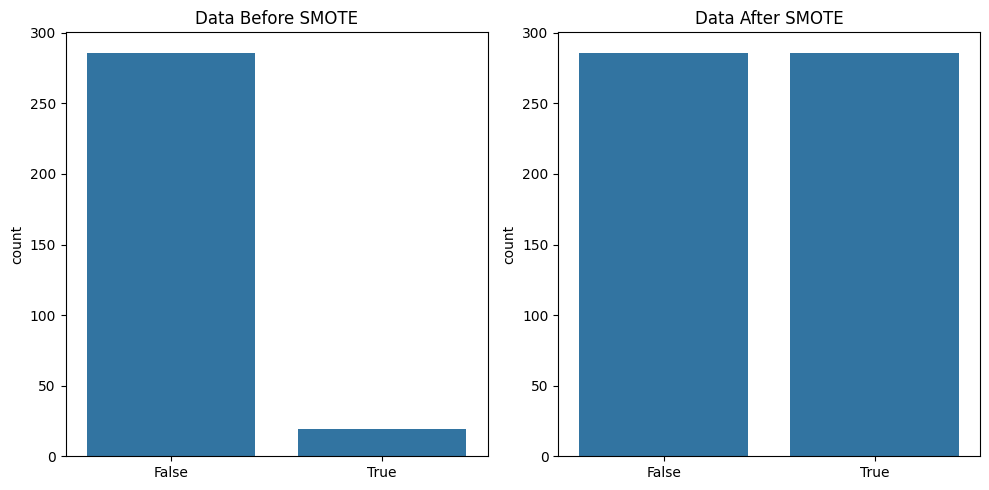

In [31]:
# Plot before SMOTE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train.values)
plt.title("Data Before SMOTE")

# Plot after SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_balanced.values)
plt.title("Data After SMOTE")

plt.tight_layout()
plt.show()

## Support Vector Machine

In [32]:
svm_balanced = svm

In [33]:
svm_balanced.fit(X_train_balanced_scaled, y_train_balanced)

Pipeline(steps=[('classifier', SVC(C=10, gamma=10, kernel='linear'))])

In [34]:
svm_balanced_metrics = show_metrics(
    "SVM Balanced", svm_balanced, X_test_scaled, y_test, show=True
)

Metrics for SVM Balanced
Precision: 0.30434782608695654
Recall: 0.5833333333333334
F1 Score: 0.4
Accuracy: 0.7272727272727273


## Random Forest 

In [35]:
rfc_balanced = rfc

In [36]:
rfc_balanced.fit(X_train_balanced_scaled, y_train_balanced)

Pipeline(steps=[('classifier', RandomForestClassifier(random_state=1))])

In [37]:
rfc_balanced_metrics = show_metrics(
    "Random Forest Balanced", rfc_balanced, X_test_scaled, y_test, show=True
)


Metrics for Random Forest Balanced
Precision: 1.0
Recall: 0.4166666666666667
F1 Score: 0.5882352941176471
Accuracy: 0.9090909090909091


## Linear Regression

In [38]:
lr_balanced = create_pipeline(LogisticRegression())

In [39]:
lr_balanced.fit(X_train_balanced_scaled, y_train_balanced)

Pipeline(steps=[('classifier', LogisticRegression())])

In [40]:
lr_balanced_metrics = show_metrics(
    "Logistic Regression Balanced",
    lr_balanced,
    X_test_scaled,
    y_test,
    show=True,
)

Metrics for Logistic Regression Balanced
Precision: 0.3181818181818182
Recall: 0.5833333333333334
F1 Score: 0.4117647058823529
Accuracy: 0.7402597402597403


## Ensemble

In [41]:
eclf_balanced = VotingClassifier(
    estimators=[
        ("svm", svm_balanced),
        ("rf", rfc_balanced),
        ("lr", lr_balanced),
    ],
    voting="hard",
)

In [42]:
eclf_balanced.fit(X_train_balanced_scaled, y_train_balanced)

VotingClassifier(estimators=[('svm',
                              Pipeline(steps=[('classifier',
                                               SVC(C=10, gamma=10,
                                                   kernel='linear'))])),
                             ('rf',
                              Pipeline(steps=[('classifier',
                                               RandomForestClassifier(random_state=1))])),
                             ('lr',
                              Pipeline(steps=[('classifier',
                                               LogisticRegression())]))])

In [43]:
eclf_balanced_metrics = show_metrics(
    "Voting Classifier Balanced", eclf_balanced, X_test_scaled, y_test, show=True
)


Metrics for Voting Classifier Balanced
Precision: 0.3888888888888889
Recall: 0.5833333333333334
F1 Score: 0.4666666666666667
Accuracy: 0.7922077922077922


## Comparison

In [44]:
metrics_matrix_balanced = np.array(
    [
        svm_balanced_metrics,
        rfc_balanced_metrics,
        lr_balanced_metrics,
        eclf_balanced_metrics,
    ]
).T

In [45]:
balanced_metrics = {
    "Model": [
        "SVM (SMOT)",
        "Random Forest (SMOT)",
        "Logistic Regression (SMOT)",
        "Voting Classifier (SMOT)",
    ],
    "Precision": metrics_matrix_balanced[0],
    "Recall": metrics_matrix_balanced[1],
    "F1 Score": metrics_matrix_balanced[2],
    "accuracy": metrics_matrix_balanced[3],
}

# Create a dataframe from the metrics dictionary
df_balanced_metrics = pd.DataFrame(balanced_metrics)


In [46]:
df_balanced_metrics

,Model,Precision,Recall,F1 Score,accuracy
0,SVM (SMOT),0.304348,0.583333,0.400000,0.727273
1,Random Forest (SMOT),1.000000,0.416667,0.588235,0.909091
2,Logistic Regression (SMOT),0.318182,0.583333,0.411765,0.740260
3,Voting Classifier (SMOT),0.388889,0.583333,0.466667,0.792208


In [47]:
pd.concat([df_metrics, df_balanced_metrics], axis=0)

,Model,Precision,Recall,F1 Score,accuracy
0,SVM,0.500000,0.083333,0.142857,0.844156
1,Random Forest,0.000000,0.000000,0.000000,0.831169
2,Logistic Regression,0.800000,0.333333,0.470588,0.883117
3,Voting Classifier,1.000000,0.083333,0.153846,0.857143
0,SVM (SMOT),0.304348,0.583333,0.400000,0.727273
1,Random Forest (SMOT),1.000000,0.416667,0.588235,0.909091
2,Logistic Regression (SMOT),0.318182,0.583333,0.411765,0.740260
3,Voting Classifier (SMOT),0.388889,0.583333,0.466667,0.792208


# Feature Selection

## Recursive Feature Elimination (RFE)

In [48]:
rfecv = RFECV(
    estimator=RandomForestClassifier(random_state=random_state, max_depth=10),
    step=1,
    cv=stratifed_kfold,
    scoring="accuracy",
)

In [49]:
X_train_rfecv, X_test_rfecv, y_train_rfecv, y_test_rfecv = prepare_data(
    df.copy(), "Defective", sm
)


### Support Vector Machine

In [50]:
svm_rfecv = create_pipeline(SVC(C=10, gamma=10, kernel="linear"), rfecv)

In [51]:
svm_rfecv.fit(X_train_rfecv, y_train_rfecv)

Pipeline(steps=[('feature_selector',
                 RFECV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
                       estimator=RandomForestClassifier(max_depth=10,
                                                        random_state=1),
                       scoring='accuracy')),
                ('classifier', SVC(C=10, gamma=10, kernel='linear'))])

In [52]:
svm_rfecv_metrics = show_metrics(
    "SVM SMOT RFECV", svm_rfecv, X_test_rfecv, y_test_rfecv, show=True
)

Metrics for SVM SMOT RFECV
Precision: 0.4117647058823529
Recall: 0.5833333333333334
F1 Score: 0.4827586206896552
Accuracy: 0.8051948051948052


### Random Forest

In [53]:
rfc_rfecv = create_pipeline(RandomForestClassifier(random_state=random_state), rfecv)

In [54]:
rfc_rfecv.fit(X_train_rfecv, y_train_rfecv)

Pipeline(steps=[('feature_selector',
                 RFECV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
                       estimator=RandomForestClassifier(max_depth=10,
                                                        random_state=1),
                       scoring='accuracy')),
                ('classifier', RandomForestClassifier(random_state=1))])

In [55]:
rfc_rfecv_metrics = show_metrics(
    "Random Forest SMOT RFECV", rfc_rfecv, X_test_rfecv, y_test_rfecv, show=True
)

Metrics for Random Forest SMOT RFECV
Precision: 1.0
Recall: 0.4166666666666667
F1 Score: 0.5882352941176471
Accuracy: 0.9090909090909091


### Logistic Regression

In [56]:
lr_rfecv = create_pipeline(LogisticRegression(), rfecv)

In [57]:
lr_rfecv.fit(X_train_rfecv, y_train_rfecv)

Pipeline(steps=[('feature_selector',
                 RFECV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
                       estimator=RandomForestClassifier(max_depth=10,
                                                        random_state=1),
                       scoring='accuracy')),
                ('classifier', LogisticRegression())])

In [58]:
lr_rfecv_metrics = show_metrics(
    "Logistic Regression SMOT RFECV", lr_rfecv, X_test_rfecv, y_test_rfecv, show=True
)

Metrics for Logistic Regression SMOT RFECV
Precision: 0.47368421052631576
Recall: 0.75
F1 Score: 0.5806451612903226
Accuracy: 0.8311688311688312


### Ensemble

In [59]:
eclf_rfecv = VotingClassifier(
    estimators=[
        ("svm", svm_rfecv),
        ("rf", rfc_rfecv),
        ("lr", lr_rfecv),
    ],
    voting="hard",
)

In [60]:
eclf_rfecv.fit(X_train_rfecv, y_train_rfecv)

VotingClassifier(estimators=[('svm',
                              Pipeline(steps=[('feature_selector',
                                               RFECV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
                                                     estimator=RandomForestClassifier(max_depth=10,
                                                                                      random_state=1),
                                                     scoring='accuracy')),
                                              ('classifier',
                                               SVC(C=10, gamma=10,
                                                   kernel='linear'))])),
                             ('rf',
                              Pipeline(steps=[('feature_selector',
                                               RFECV(cv=StratifiedKFold(n_splits=...
                                                     estimator=RandomForestClassifier(max_depth=10,
                                                                                      random_state=1),
                                                     scoring='accuracy')),
                                              ('classifier',
                                               RandomForestClassifier(random_state=1))])),
                             ('lr',
                              Pipeline(steps=[('feature_selector',
                                               RFECV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
                                                     estimator=RandomForestClassifier(max_depth=10,
                                                                                      random_state=1),
                                                     scoring='accuracy')),
                                              ('classifier',
                                               LogisticRegression())]))])

In [61]:
eclf_rfecv_metrics = show_metrics(
    "Voting Classifier SMOT RFECV", eclf_rfecv, X_test_rfecv, y_test_rfecv, show=True
)

Metrics for Voting Classifier SMOT RFECV
Precision: 0.4444444444444444
Recall: 0.6666666666666666
F1 Score: 0.5333333333333333
Accuracy: 0.8181818181818182


## Comparison

In [62]:
metrics_matrix_rfecv = np.array(
    [svm_rfecv_metrics, rfc_rfecv_metrics, lr_rfecv_metrics, eclf_rfecv_metrics]
).T


In [63]:
rfecv_metrics = {
    "Model": [
        "SVM (SMOT RFECV)",
        "Random Forest (SMOT RFECV)",
        "Logistic Regression (SMOT RFECV)",
        "Voting Classifier (SMOT RFECV)",
    ],
    "Precision": metrics_matrix_rfecv[0],
    "Recall": metrics_matrix_rfecv[1],
    "F1 Score": metrics_matrix_rfecv[2],
    "accuracy": metrics_matrix_rfecv[3],
}

# Create a dataframe from the metrics dictionary
df_rfecv_metrics = pd.DataFrame(rfecv_metrics)


In [64]:
df_rfecv_metrics

,Model,Precision,Recall,F1 Score,accuracy
0,SVM (SMOT RFECV),0.411765,0.583333,0.482759,0.805195
1,Random Forest (SMOT RFECV),1.000000,0.416667,0.588235,0.909091
2,Logistic Regression (SMOT RFECV),0.473684,0.750000,0.580645,0.831169
3,Voting Classifier (SMOT RFECV),0.444444,0.666667,0.533333,0.818182


## Chi-Squared

In [65]:
chi2_selector = SelectKBest(chi2, k=10)

In [66]:
# Rescaling the data from 0 to 1 for chi2
X_train_chi, X_test_chi, y_train_chi, y_test_chi = prepare_data(
    df.copy(), "Defective", sm, scaler=MinMaxScaler(feature_range=(0, 1))
)

### Support Vector Machine

In [67]:
svm_chi = create_pipeline(SVC(C=10, gamma=10, kernel="linear"), chi2_selector)

In [68]:
svm_chi.fit(X_train_chi, y_train_chi)

Pipeline(steps=[('feature_selector',
                 SelectKBest(score_func=<function chi2 at 0x0000014F11C99B80>)),
                ('classifier', SVC(C=10, gamma=10, kernel='linear'))])

In [69]:
svm_chi_metrics = show_metrics(
    "SVM SMOT Chi2", svm_chi, X_test_chi, y_test_chi, show=True
)

Metrics for SVM SMOT Chi2
Precision: 0.47368421052631576
Recall: 0.75
F1 Score: 0.5806451612903226
Accuracy: 0.8311688311688312


### Random Forest

In [70]:
rfc_chi = create_pipeline(
    RandomForestClassifier(random_state=random_state), chi2_selector
)

In [71]:
rfc_chi.fit(X_train_chi, y_train_chi)

Pipeline(steps=[('feature_selector',
                 SelectKBest(score_func=<function chi2 at 0x0000014F11C99B80>)),
                ('classifier', RandomForestClassifier(random_state=1))])

In [72]:
rfc_chi_metrics = show_metrics(
    "Random Forest SMOT Chi2", rfc_chi, X_test_chi, y_test_chi, show=True
)

Metrics for Random Forest SMOT Chi2
Precision: 0.7142857142857143
Recall: 0.4166666666666667
F1 Score: 0.5263157894736842
Accuracy: 0.8831168831168831


### Logistic Regression

In [73]:
lr_chi = create_pipeline(LogisticRegression(), chi2_selector)

In [74]:
lr_chi.fit(X_train_chi, y_train_chi)

Pipeline(steps=[('feature_selector',
                 SelectKBest(score_func=<function chi2 at 0x0000014F11C99B80>)),
                ('classifier', LogisticRegression())])

In [75]:
lr_chi_metrics = show_metrics(
    "Logistic Regression SMOT Chi2", lr_chi, X_test_chi, y_test_chi, show=True
)

Metrics for Logistic Regression SMOT Chi2
Precision: 0.5
Recall: 0.8333333333333334
F1 Score: 0.625
Accuracy: 0.8441558441558441


### Ensemble

In [76]:
eclf_chi = VotingClassifier(
    estimators=[
        ("svm", svm_chi),
        ("rf", rfc_chi),
        ("lr", lr_chi),
    ],
    voting="hard",
)

In [77]:
ecf_chi = eclf_chi.fit(X_train_chi, y_train_chi)

In [78]:
eclf_chi_metrics = show_metrics(
    "Voting Classifier SMOT Chi2", eclf_chi, X_test_chi, y_test_chi, show=True
)

Metrics for Voting Classifier SMOT Chi2
Precision: 0.47368421052631576
Recall: 0.75
F1 Score: 0.5806451612903226
Accuracy: 0.8311688311688312


## Comparison

In [79]:
metrics_matrix_chi = np.array(
    [svm_chi_metrics, rfc_chi_metrics, lr_chi_metrics, eclf_chi_metrics]
).T

In [80]:
chi_metrics = {
    "Model": [
        "SVM (SMOT Chi2)",
        "Random Forest (SMOT Chi2)",
        "Logistic Regression (SMOT Chi2)",
        "Voting Classifier (SMOT Chi2)",
    ],
    "Precision": metrics_matrix_chi[0],
    "Recall": metrics_matrix_chi[1],
    "F1 Score": metrics_matrix_chi[2],
    "accuracy": metrics_matrix_chi[3],
}

# Create a dataframe from the metrics dictionary
df_chi_metrics = pd.DataFrame(chi_metrics)

In [81]:
df_chi_metrics

,Model,Precision,Recall,F1 Score,accuracy
0,SVM (SMOT Chi2),0.473684,0.750000,0.580645,0.831169
1,Random Forest (SMOT Chi2),0.714286,0.416667,0.526316,0.883117
2,Logistic Regression (SMOT Chi2),0.500000,0.833333,0.625000,0.844156
3,Voting Classifier (SMOT Chi2),0.473684,0.750000,0.580645,0.831169


In [82]:
all_metrics = pd.concat(
    [df_metrics, df_balanced_metrics, df_rfecv_metrics, df_chi_metrics], axis=0
)

In [83]:
all_metrics.to_csv(f"../metrics/{df_name}-metrics.csv", index=False)